In [1]:
%matplotlib inline
import os
import scipy
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from plotnine import *
import arviz as az
import geopandas
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

# Data

In [6]:
# data
df = pd.read_csv('all_national_indicators.csv')
df.columns = df.columns.str.replace('.', '_')

# add 'un_region_name' and 'un_subregion_2' to Taiwan
df.loc[df.country_name_en =='Taiwan', 'un_region_name'] = 'Asia'
df.loc[df.country_name_en =='Taiwan', 'un_subregion_2'] = 'Eastern Asia'

# new variables
df['mean_aquaculture_production'] = df[['mean_aquaculture_production_freshwater','mean_aquaculture_production_marine','mean_aquaculture_production_brackish']].sum(axis=1)
df['unit_exports'] = df['mean_exports_USD1000'] / df['mean_exports_tonnes']
df['unit_imports'] = df['mean_imports_USD1000'] / df['mean_imports_tonnes']

# log transform highly skewed variables
df['sat_model_est_wealth'] = np.log(df['sat_model_est_wealth'] + 1)
df['eez_total'] = np.log(df['eez_total'] + 1)
df['inland_water_max'] = np.log(df['inland_water_max'] + 1)
df['mean_capture_production'] = np.log(df['mean_capture_production'] + 1)
df['mean_aquaculture_production'] = np.log(df['mean_aquaculture_production'] + 1)
df['unit_exports'] = np.log(df['unit_exports'] + 1)
df['unit_imports'] = np.log(df['unit_imports'] + 1)

# response variable
y = df['direct_w_esitimated_ssf'] + df['indirect_w_esitimated_ssf']

# scale by 100/IQR to use the same prior for intercepts across models
q = np.nanquantile(y, [0.25, 0.75])
scale_factor =  100/(q[1] - q[0])
y_scaled = y * scale_factor
y_scaled = y_scaled[~y_scaled.isnull()].copy()

# predictor variables of inetrest
cov = ['mean_educ', 'sat_model_est_wealth', 'gender_equality', 'language_diversity',
    'cultural_hegemony', 'working_percent_sat_mean', 'mean_voice_account']
cov_name = ['Education', 'Wealth', 'Gender equality', 'Language diversity',
    'Cultural hegemony', 'Age dependency', 'Voice and accountability']
x_cov = df[cov].copy()

# nuisance variables
nuisance = ['mean_capture_production', 'mean_aquaculture_production']
x_nuisance = df[nuisance].copy()

# merge
X = x_cov.merge(x_nuisance, left_index=True, right_index=True)

# add population (log) to help impute missing predictors
X['log_pop'] = np.log(df['mean_population']+ 1)

# standardize all predictors
def standardize(x):
    return (x-np.mean(x))/np.std(x)

X = X.apply(standardize, axis=0)
 
# remove predictors without a response variable
X = X.loc[y_scaled.index, :].copy()

In [7]:
X.head()

,mean_educ,sat_model_est_wealth,gender_equality,language_diversity,cultural_hegemony,working_percent_sat_mean,mean_voice_account,mean_capture_production,mean_aquaculture_production,log_pop
1,0.240722,2.587840,NaN,0.953349,1.559748,2.990916,-0.995582,0.486857,0.188212,0.322796
3,NaN,NaN,NaN,0.312662,0.424008,NaN,0.608056,-0.400992,-0.770440,-1.543633
5,-0.141151,0.219452,0.032329,0.272619,-0.763399,0.770128,0.149322,-0.206289,0.479459,-0.103360
7,-1.184546,-0.972918,0.544568,1.090162,-0.763399,-2.010915,-1.102661,0.914919,-0.008931,0.771826
9,0.209174,0.304386,1.816876,-0.855258,-0.560990,0.025789,0.407357,1.164759,0.492698,0.990736


In [8]:
y_scaled.head()

1    11.179190
3     2.450822
5     4.084704
7    93.518220
9    11.394174
dtype: float64

#### _Mask NAs in predictors_

In [9]:
X_masked = np.ma.masked_invalid(X)

#### _Regional and national indices_

In [10]:
region = list(set(df.loc[X.index, 'un_subregion_2']))
region_dict = {x:i for i, x in enumerate(region)}
region_index = [region_dict.get(x) for x in df.loc[X.index, 'un_subregion_2']]
nation_index = list(range(X.shape[0]))

# Model

In [11]:
with pm.Model() as model:

    # global intercept and sd
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    sigma_0 = pm.HalfCauchy('sigma_0', beta=5)

    # regional intercept
    mu_i_offset = pm.Normal('mu_i_offset', mu=0, sigma=1, shape=len(region))
    mu_i = pm.Deterministic('mu_i', mu_0 + mu_i_offset * sigma_0)
    alpha_i = pm.HalfCauchy('alpha_i', beta=5)
    beta_i = pm.HalfCauchy('beta_i', beta=5)
    sigma2_i = pm.InverseGamma('sigma2_i', alpha=alpha_i, beta=beta_i, shape=len(region))
    sigma_i = pm.Deterministic('sigma_i', sigma2_i ** 0.5)

    # national intercept
    mu_j_offset = pm.Normal('mu_j_offset', mu=0, sigma=1, shape=X.shape[0])
    mu_j = pm.Deterministic('mu_j', mu_i[region_index] + mu_j_offset[nation_index] * sigma_i[region_index])
    # slope
    beta = pm.Normal('beta', mu=0, sigma=10, shape=X.shape[1]-1)   # removing log-population

    # shape parameter for gamma error
    alpha = pm.HalfCauchy('alpha', beta=5)

    # impute missing X
    chol, _, _ = pm.LKJCholeskyCov('chol', n=X_masked.shape[1], eta=2, sd_dist=pm.Exponential.dist(lam=1), compute_corr=True)
    cov = pm.Deterministic('cov', chol.dot(chol.T))
    X_mu = pm.Normal('X_mu', mu=0, sigma=100, shape=X.shape[1], testval=X_masked.mean(axis=0))
    X_modeled = pm.MvNormal('X', mu=X_mu, chol=chol, observed=X_masked)

    # observation
    mu_ = mu_j[nation_index] + tt.dot(X_modeled[:,:-1], beta)   # removing log-population

    # likelihood
    mu = tt.exp(mu_)
    likelihood = pm.Gamma('y', alpha=alpha, beta=alpha/mu, observed=y_scaled)    

In [12]:
# sample
with model:
    trace = pm.sample(5000, tune=2000, chains=2, target_accept=0.95)

There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


#### _Trace plot_

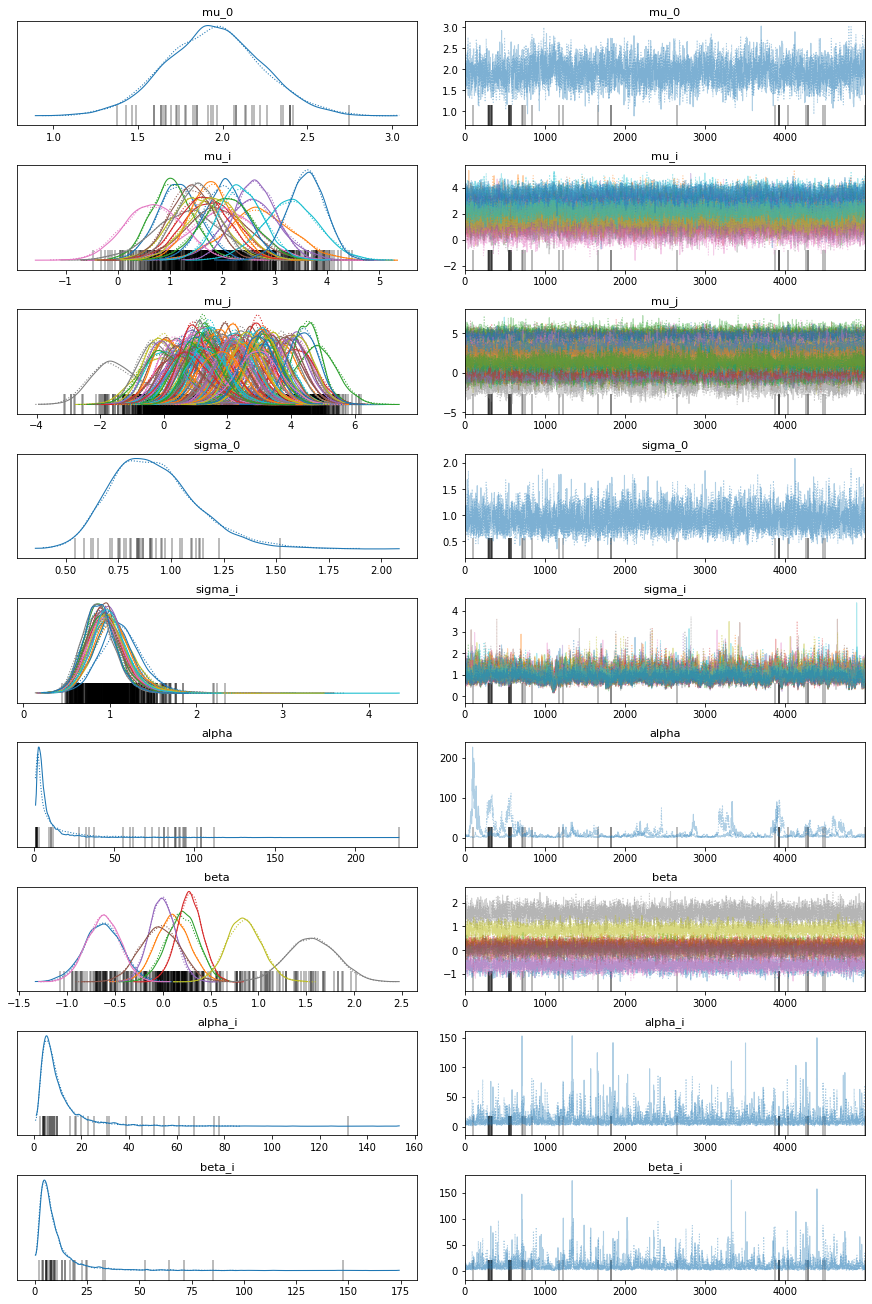

In [13]:
pm.traceplot(trace, var_names=['mu_0', 'mu_i', 'mu_j', 'sigma_0', 'sigma_i', 'alpha', 'beta', 'alpha_i', 'beta_i']);

# Summary

In [15]:
summary_coef = np.quantile(trace.beta, axis=0, q=[0.5, 0.025, 0.25, 0.75, 0.975])
summary_coef = pd.DataFrame(np.transpose(summary_coef))
summary_coef.index = X.columns[:-1]
summary_coef.columns = ['median', 'lower95', 'lower50', 'upper50', 'upper95']
summary_coef['rhat'] = az.rhat(trace).beta
summary_coef = summary_coef.drop(index=x_nuisance.columns)
summary_coef

,median,lower95,lower50,upper50,upper95,rhat
mean_educ,-0.624223,-1.015432,-0.756672,-0.491550,-0.234591,1.001910
sat_model_est_wealth,0.100351,-0.249110,-0.019490,0.219359,0.440905,1.000492
gender_equality,0.201425,-0.141155,0.085900,0.314475,0.525363,1.000454
language_diversity,0.278836,0.009451,0.191430,0.367283,0.537635,1.000195
cultural_hegemony,-0.005539,-0.273528,-0.095766,0.088795,0.274515,1.000843
working_percent_sat_mean,-0.030120,-0.427424,-0.170690,0.110033,0.370719,1.000121
mean_voice_account,-0.621771,-0.968147,-0.741735,-0.504948,-0.283112,1.000029


#### _Plot_

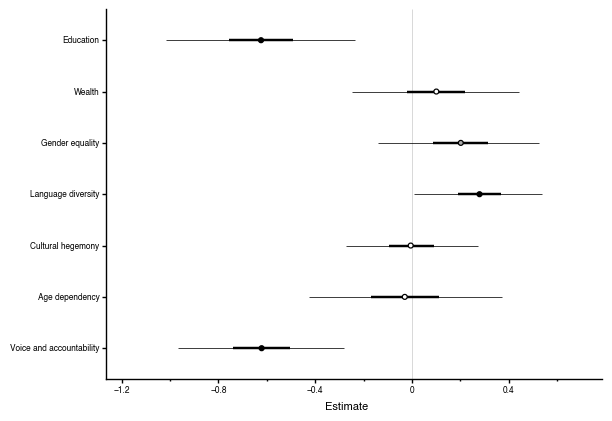

<ggplot: (323504583)>

In [16]:
summary_coef['var_name'] = cov_name
summary_coef = summary_coef[::-1]
summary_coef['var_name'] = pd.Categorical(summary_coef['var_name'], categories=summary_coef['var_name'])

# point color
foo = zip(summary_coef.lower95 * summary_coef.upper95, summary_coef.lower50 * summary_coef.upper50)
col = ['#000000' if x1 > 0 else '#aaaaaa' if x2 > 0 else '#ffffff' for (x1, x2) in foo]

# axis range
min_val = summary_coef.lower95.min()
max_val = summary_coef.upper95.max()
min_range = min_val - (max_val - min_val) * 0.1
max_range = max_val + (max_val - min_val) * 0.1

p = ggplot(aes(x='var_name', y='median'), data=summary_coef) + \
    geom_hline(yintercept=0, colour='#cccccc', size=0.3) + \
    geom_errorbar(aes(ymin='lower95', ymax='upper95', size=1, width=0)) + \
    geom_errorbar(aes(ymin='lower50', ymax='upper50', size=2, width=0)) + \
    scale_size_continuous(range=[0.3,1]) + \
    geom_point(size=1.5, fill=col) + \
    scale_y_continuous(limits=[min_range, max_range]) + \
    labs(x='', y='Estimate') + \
    coord_flip() + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_position='none')
p

# Deviation analysis

In [18]:
# estimates for regional mu and sigma
mu_i = np.quantile(trace.mu_i, axis=0, q=0.5)
sigma_i = np.quantile(trace.sigma_i, axis=0, q=0.5)

data = pd.DataFrame()
data['region_index'] = region_index
data['region'] = [region[x] for x in data.region_index]
data['country'] = df.loc[y_scaled.index, 'country_name_en'].values
data['iso3'] = df.loc[y_scaled.index, 'iso3c'].values
data['mu_j'] = np.quantile(trace.mu_j, axis=0, q=0.5)
data['mu_i'] = [mu_i[x] for x in data.region_index]
data['sigma_i'] = [sigma_i[x] for x in data.region_index]
data['sd'] = (data.mu_j - data.mu_i)/data.sigma_i
data['region_intercept'] = np.exp(data.mu_i) / scale_factor
data['nation_intercept'] = np.exp(data.mu_j) / scale_factor
data.head()

,region_index,region,country,iso3,mu_j,mu_i,sigma_i,sd,region_intercept,nation_intercept
0,0,Western Asia,United Arab Emirates,ARE,0.948376,1.168323,1.121639,-0.196095,14.961991,12.007907
1,20,Caribbean,Antigua & Barbuda,ATG,3.016015,3.612522,0.878955,-0.678655,172.381856,94.936207
2,17,Southern Europe,Albania,ALB,1.342006,1.513954,0.859288,-0.200105,21.139502,17.799943
3,8,Middle Africa,Angola,AGO,1.411437,1.485662,1.038571,-0.071468,20.549807,19.079739
4,10,South America,Argentina,ARG,0.806824,2.052098,1.028667,-1.210570,36.208273,10.422989


#### _Plot deviations_

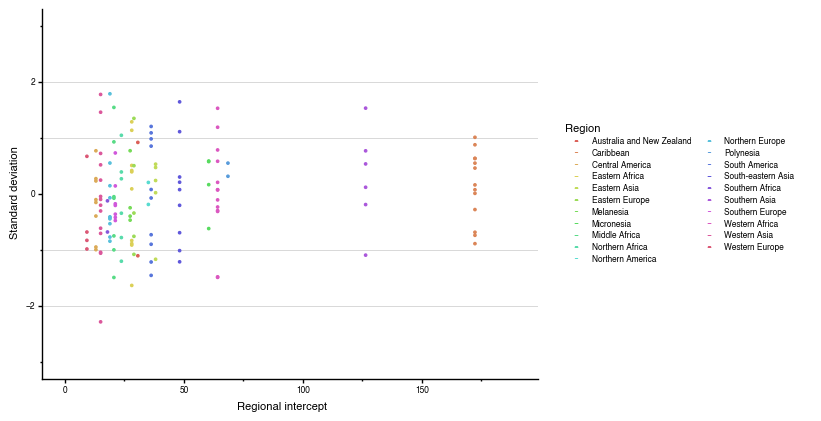

<ggplot: (321042679)>

In [21]:
p = ggplot(aes(x='region_intercept', y='sd'), data=data) + \
    geom_hline(yintercept=[-2,-1,1,2], color='#cccccc', size=0.3) + \
    geom_point(aes(color='region'), size=0.5) + \
    lims(x=[0,data.region_intercept.max()*1.1], y=[-3,3]) + \
    labs(x='Regional intercept', y='Standard deviation', color='Region') + \
    guides(color=guide_legend(ncol=2, keyheight=1)) + \
    theme_classic() + \
    theme(axis_text=element_text(size=6, colour='black', family='Helvetica'),
        axis_title=element_text(size=8, colour='black', family='Helvetica'),
        axis_line=element_line(color='black'),
        axis_ticks=element_line(color='black'),
        legend_title=element_text(size=8, colour='black', family='Helvetica'),
        legend_text=element_text(size=6, colour='black', family='Helvetica'))
p

#### _Plot a map_

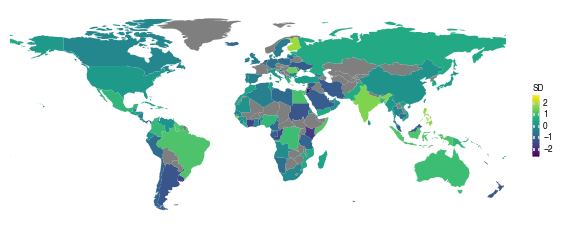

<ggplot: (322727325)>

In [23]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.merge(data, how='left', left_on='iso_a3', right_on='iso3')
world.drop(world[world.iso_a3=='ATA'].index, inplace=True)

p = ggplot() + \
    geom_map(aes(fill='sd'), world, stroke=0, size=0) + \
    coord_equal() + \
    scale_x_continuous(limits=[-180, 180], expand=[0,0]) + \
    scale_y_continuous(limits=[-70, 90], expand=[0,0]) + \
    scale_fill_continuous(name='SD', limits=[-2.5, 2.5]) + \
    guides(fill=guide_colourbar(barwidth=3, barheight=6)) + \
    theme(plot_title=element_text(hjust=0, face=2, size=8, colour='black', family='Helvetica'),
        legend_title=element_text(size=6, colour='black', family='Helvetica'),
        legend_text=element_text(size=6, colour='black', family='Helvetica'),
        panel_grid_major=element_blank(),
        panel_grid_minor=element_blank(),
        axis_ticks=element_blank(),
        axis_text=element_blank(),
        axis_title=element_blank(),
        panel_background=element_rect(color='none', fill='none'))
p